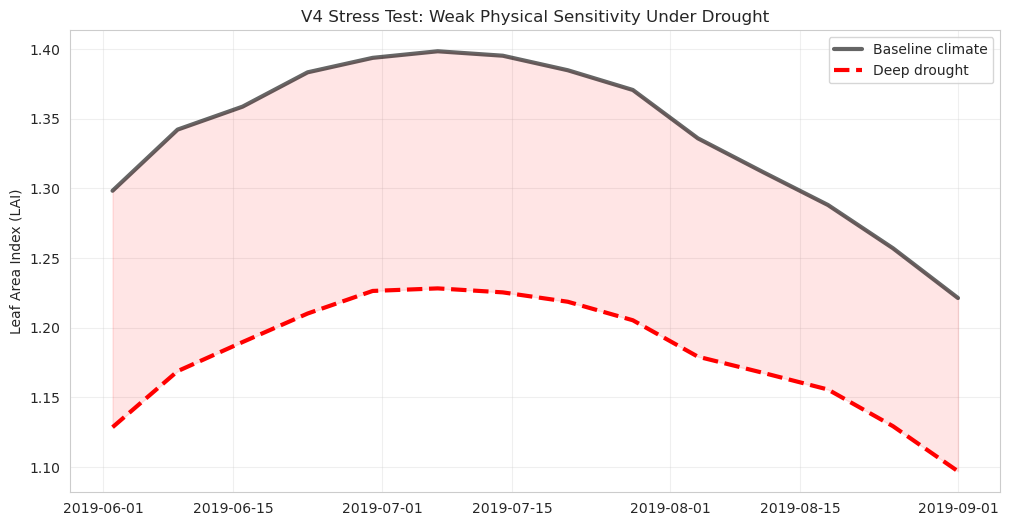

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ------------------------------------------
# Settings
# ------------------------------------------
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

CSV_FILE = 'master_data_for_all_models_weekly.csv'
TARGET_COL = 'LAI'
SEQ_LENGTH = 12
TRAIN_END = '2018-12-31'

BASE_FEATURES = [
    "total_precipitation",
    "volumetric_soil_water_layer_1",
    "volumetric_soil_water_layer_2",
    "2m_temperature",
    "surface_solar_radiation_downwards",
    "evaporation",
    "specific_humidity"
]

# ------------------------------------------
# Model
# ------------------------------------------
class LSTM_Robust(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, 1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ------------------------------------------
# Data utilities
# ------------------------------------------
def process_data(df):
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['LAI_lag_1'] = df[TARGET_COL].shift(1)
    return df.dropna()


def create_loader(df, features):
    train = df.loc[:TRAIN_END]

    sx = MinMaxScaler().fit(train[features])
    sy = MinMaxScaler().fit(train[[TARGET_COL]])

    Xs = sx.transform(train[features])
    ys = sy.transform(train[[TARGET_COL]])

    X, y = [], []
    for i in range(len(Xs) - SEQ_LENGTH):
        X.append(Xs[i:i + SEQ_LENGTH])
        y.append(ys[i + SEQ_LENGTH])

    loader = DataLoader(
        TensorDataset(torch.tensor(X).float(), torch.tensor(y).float()),
        batch_size=16,
        shuffle=True
    )

    return loader, sx, sy

# ------------------------------------------
# Training
# ------------------------------------------
def train_model(model, loader, epochs=60):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()
    return model

# ------------------------------------------
# Drought stress trajectory
# ------------------------------------------
def generate_drought_trajectory(model, df, features, sx, sy):
    idxs = np.where((df.index >= '2019-06-01') & (df.index <= '2019-09-01'))[0]
    dates = df.index[idxs]

    base_preds, drought_preds = [], []
    model.eval()

    for idx in idxs:
        seq = df.iloc[idx - SEQ_LENGTH + 1: idx + 1]
        if len(seq) != SEQ_LENGTH:
            continue

        x_base = sx.transform(seq[features])
        with torch.no_grad():
            p_base = sy.inverse_transform(
                model(torch.tensor(x_base).float().unsqueeze(0)).numpy()
            )[0, 0]
        base_preds.append(p_base)

        drought = seq.copy()
        for f in [
            'total_precipitation',
            'volumetric_soil_water_layer_1',
            'volumetric_soil_water_layer_2'
        ]:
            if f in drought.columns:
                drought[f] = 0.0

        x_drought = sx.transform(drought[features])
        with torch.no_grad():
            p_drought = sy.inverse_transform(
                model(torch.tensor(x_drought).float().unsqueeze(0)).numpy()
            )[0, 0]
        drought_preds.append(p_drought)

    return dates, base_preds, drought_preds

# ------------------------------------------
# Visualization (single figure)
# ------------------------------------------
def plot_trajectory(dates, base_preds, drought_preds):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, base_preds, linewidth=3, color='black', alpha=0.6,
             label='Baseline climate')
    plt.plot(dates, drought_preds, linewidth=3, linestyle='--', color='red',
             label='Deep drought')
    plt.fill_between(dates, base_preds, drought_preds, color='red', alpha=0.1)
    plt.title('V4 Stress Test: Weak Physical Sensitivity Under Drought')
    plt.ylabel('Leaf Area Index (LAI)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# ------------------------------------------
# Main
# ------------------------------------------
def main():
    df = pd.read_csv(CSV_FILE, index_col='time', parse_dates=True).sort_index()
    if df.index.freq is None:
        df = df.asfreq('W').ffill()

    df = process_data(df)

    features = BASE_FEATURES + ['LAI_lag_1', 'month_sin', 'month_cos']

    loader, sx, sy = create_loader(df, features)
    model = train_model(LSTM_Robust(len(features)), loader)

    dates, base_preds, drought_preds = generate_drought_trajectory(
        model, df, features, sx, sy
    )

    plot_trajectory(dates, base_preds, drought_preds)


if __name__ == '__main__':
    main()

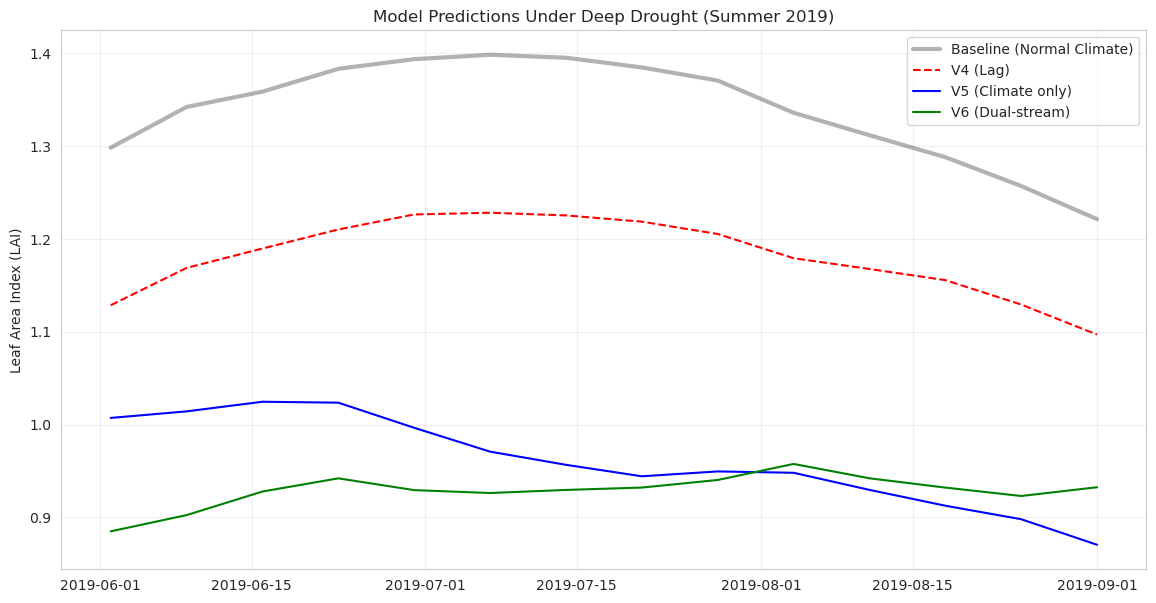

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings

# ------------------------------------------
# Settings
# ------------------------------------------
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings("ignore")

CSV_FILE = 'master_data_for_all_models_weekly.csv'
TARGET_COL = 'LAI'
SEQ_LENGTH = 12
TRAIN_END = '2018-12-31'

BASE_FEATURES = [
    "total_precipitation",
    "volumetric_soil_water_layer_1",
    "volumetric_soil_water_layer_2",
    "2m_temperature",
    "surface_solar_radiation_downwards",
    "evaporation",
    "specific_humidity"
]

# ------------------------------------------
# Models
# ------------------------------------------
class LSTM_Robust(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, 1))

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class LSTM_DualStream_V6(nn.Module):
    def __init__(self, climate_dim, lag_dim, dropout_rate=0.5):
        super().__init__()
        self.lstm_climate = nn.LSTM(climate_dim, 32, batch_first=True)
        self.fc_inertia = nn.Sequential(nn.Linear(lag_dim, 16), nn.ReLU())
        self.fusion = nn.Sequential(nn.Linear(48, 16), nn.ReLU(), nn.Linear(16, 1))
        self.lag_dropout = nn.Dropout(dropout_rate)
        self.climate_dim = climate_dim

    def forward(self, x):
        c = x[:, :, :self.climate_dim]
        i = x[:, :, self.climate_dim:]
        c_out, _ = self.lstm_climate(c)
        c_feat = c_out[:, -1, :]
        i_feat = self.fc_inertia(i[:, -1, :])
        if self.training:
            i_feat = self.lag_dropout(i_feat)
        return self.fusion(torch.cat([c_feat, i_feat], dim=1))

    def update_dropout(self, rate):
        self.lag_dropout.p = rate

# ------------------------------------------
# Data utilities
# ------------------------------------------
def process_data(df):
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['LAI_lag_1'] = df[TARGET_COL].shift(1)
    return df.dropna()


def create_loader(df, features):
    train = df.loc[:TRAIN_END]
    sx = MinMaxScaler().fit(train[features])
    sy = MinMaxScaler().fit(train[[TARGET_COL]])

    Xs = sx.transform(train[features])
    ys = sy.transform(train[[TARGET_COL]])

    X, y = [], []
    for i in range(len(Xs) - SEQ_LENGTH):
        X.append(Xs[i:i + SEQ_LENGTH])
        y.append(ys[i + SEQ_LENGTH])

    loader = DataLoader(
        TensorDataset(torch.tensor(X).float(), torch.tensor(y).float()),
        batch_size=16,
        shuffle=True
    )

    return loader, sx, sy

# ------------------------------------------
# Training
# ------------------------------------------
def train_model(model, loader, curriculum=False):
    opt = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.MSELoss()

    for epoch in range(60):
        model.train()
        if curriculum:
            model.update_dropout(1.0 if epoch < 20 else 0.5)
        for xb, yb in loader:
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()
    return model

# ------------------------------------------
# Drought trajectory
# ------------------------------------------
def drought_trajectory(model, df, features, sx, sy):
    idxs = np.where((df.index >= '2019-06-01') & (df.index <= '2019-09-01'))[0]
    dates = df.index[idxs]

    base, drought = [], []
    model.eval()

    for idx in idxs:
        seq = df.iloc[idx - SEQ_LENGTH + 1: idx + 1]
        if len(seq) != SEQ_LENGTH:
            continue

        xb = sx.transform(seq[features])
        with torch.no_grad():
            pb = sy.inverse_transform(
                model(torch.tensor(xb).float().unsqueeze(0)).numpy()
            )[0, 0]
        base.append(pb)

        d = seq.copy()
        for f in ['total_precipitation', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2']:
            if f in d.columns:
                d[f] = 0.0

        xd = sx.transform(d[features])
        with torch.no_grad():
            pd = sy.inverse_transform(
                model(torch.tensor(xd).float().unsqueeze(0)).numpy()
            )[0, 0]
        drought.append(pd)

    return dates, base, drought

# ------------------------------------------
# Plot
# ------------------------------------------
def plot_predictions(dates, results):
    plt.figure(figsize=(14, 7))

    plt.plot(dates, results['V4']['Baseline'], color='black', alpha=0.3, linewidth=3,
             label='Baseline (Normal Climate)')

    plt.plot(dates, results['V4']['Drought'], '--', color='red', label='V4 (Lag)')
    plt.plot(dates, results['V5']['Drought'], color='blue', label='V5 (Climate only)')
    plt.plot(dates, results['V6']['Drought'], color='green', label='V6 (Dual-stream)')

    plt.title('Model Predictions Under Deep Drought (Summer 2019)')
    plt.ylabel('Leaf Area Index (LAI)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# ------------------------------------------
# Main
# ------------------------------------------
def main():
    df = pd.read_csv(CSV_FILE, index_col='time', parse_dates=True).sort_index()
    if df.index.freq is None:
        df = df.asfreq('W').ffill()

    df = process_data(df)

    feats_full = BASE_FEATURES + ['LAI_lag_1', 'month_sin', 'month_cos']
    feats_clim = BASE_FEATURES + ['month_sin', 'month_cos']

    results = {}

    loader4, sx4, sy4 = create_loader(df, feats_full)
    m4 = train_model(LSTM_Robust(len(feats_full)), loader4)
    dates, b4, d4 = drought_trajectory(m4, df, feats_full, sx4, sy4)
    results['V4'] = {'Baseline': b4, 'Drought': d4}

    loader5, sx5, sy5 = create_loader(df, feats_clim)
    m5 = train_model(LSTM_Robust(len(feats_clim)), loader5)
    _, b5, d5 = drought_trajectory(m5, df, feats_clim, sx5, sy5)
    results['V5'] = {'Baseline': b5, 'Drought': d5}

    m6 = LSTM_DualStream_V6(len(BASE_FEATURES), 3)
    m6 = train_model(m6, loader4, curriculum=True)
    _, b6, d6 = drought_trajectory(m6, df, feats_full, sx4, sy4)
    results['V6'] = {'Baseline': b6, 'Drought': d6}

    plot_predictions(dates, results)


if __name__ == '__main__':
    main()
